<a id='toc'></a>

# Solving ODEs with Photonic Modulator Neurons

This notebook was created to support the publication of an article titled [_Neuromorphic photonic networks using silicon photonic weight banks_](https://doi.org/10.1038/s41598-017-07754-z), authored by Alexander N. Tait, Ellen Zhou, Thomas Ferreira de Lima, Allie X. Wu, Mitchell A. Nahmias, Bhavin J. Shastri and Paul R. Prucnal, posted to arXiv on 5 Nov 2016.

A copy of this notebook is available at: 

https://github.com/lightwave-lab/Neuromorphic_Silicon_Photonics

This notebook produces `nengo_results.mat` for processing in matlab.

In [1]:
# The following notebook was run using Python 3.6.0 and nengo 2.2.0
# Setting up notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-colorblind')

from matplotlib import rc, rcParams
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':7})
rc('text', usetex=True)
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath}']

import nengo
# %load_ext nengo.ipynb

<a id='fourier_neuron_nengo'></a>

## Modifications to the nengo project

Nengo is based exclusively on monotonic, non-negative output neuron models. However, its encoding-decoding algorithms should work with other kinds of neuron models. Here, we use the following `FourierSinusoid` class of neurons included in our fork of the [nengo project](https://github.com/nengo/nengo/).

```python
# In nengo/neurons.py
class FourierSinusoid(NeuronType):
    """A neuron model whose response curve is a half-period of a
    sinusoidal curve.

    DISCLAIMER: This class was hijacked. The new interpretation of
    intercepts and max_rates are as follows is as follows:
    intercepts : phase at dot(x, e) = 0
        (-0.5, 0.5)
    max_rates : directly proportional to gain.
        i.e. how many periods do we want between dot(x, e) = -1 and 1
    """

    probeable = ('rates', )

    s_pi = NumberParam('s_pi', low=0)

    def __init__(self, max_overall_rate=400, s_pi=0.1):
        super(FourierSinusoid, self).__init__()
        self.max_overall_rate = max_overall_rate
        self.s_pi = s_pi

    def gain_bias_old(self, max_rates, intercepts):
        """Determine gain and bias by shifting and scaling the lines."""

        gain = max_rates * self.s_pi
        with np.errstate(divide='ignore', invalid='ignore'):
            bias = np.divide(intercepts, gain)
        bias = np.where(~np.isfinite(np.abs(bias)), 0, bias)
        return gain, bias

    def gain_bias(self, max_rates, intercepts):
        """Determine gain and bias by shifting and scaling the lines.
        This one foregoes any calculation"""
        gain = max_rates
        bias = intercepts
        return gain, bias

    # def step_math_old(self, dt, J, output, voltage):
    #     """Implement the nonlinearity."""
    #     # basically the formula is output = 0.5*(1 + sin(J/s_pi * pi))
    #     voltage = J / self.s_pi

    #     output[...] = self.max_overall_rate * 0.5 * \
    #         (1 + np.sin(np.pi * voltage))

    def step_math(self, dt, J, output):
        """Implement the nonlinearity.
        This one allows for negative outputs"""
        # basically the formula is output = 0.5*(1 + sin(J/s_pi * pi))
        voltage = J / self.s_pi

        output[...] = self.max_overall_rate * 0.5 * (np.sin(np.pi * voltage) + 1)
```

<a id='lorenz'></a>

## The Lorenz chaotic attractor

In this simulation, we chose to construct a neural network using the neurons defined [above](#fourier_neuron_nengo) to solve a classical chaotic dynamical system named "Lorenz attractor".

The equations are:
        
$$
\dot{x}_0 = \nu(x_1 - x_0) \\
\dot{x}_1 = x_0 (\rho - x_2) - x_1  \\
\dot{x}_2 = x_0 x_1 - \beta x_2 
$$

Since $x_2$ is centered around approximately $\rho$, and since NEF ensembles are usually optimized to represent values within a certain radius of the origin, we substitute $x_2' = x_2 - \rho$, giving these equations:
$$
\dot{x}_0 = \nu(x_1 - x_0) \\
\dot{x}_1 = - x_0 x_2' - x_1\\
\dot{x}_2' = x_0 x_1 - \beta (x_2' + \rho)
$$

Refer to the standard example of the Lorenz attractor solver with 2000 neurons in a [nengo example](https://github.com/nengo/nengo/blob/master/examples/dynamics/lorenz_attractor.ipynb).
*Note that the last equation for $x_2'$ is typically shown with an error in that example and in other articles from Prof. Eliasmith's group.

<a id="encoding_strategy"></a>

## Encoding strategy

From here onwards, we will refer the Lorenz system in its reduced form as as $\vec x = f(\vec x)$, with:

$$
\vec x = [x_0, x_1, x_2']^T
$$

and

$$
f(\vec x) = \left[
\begin{array}{c}
\nu(x_1 - x_0) \\
- x_0 x_2'- x_1 \\
x_0 x_1 - \beta (x_2' + \rho)
\end{array}
\right]
$$

### Neuron model
Using [nengo](http://www.nengo.ca), we instantiate a population of $N$ neurons that are all-to-all interconnected. These neurons are responsible of _representing_ the vector $\vec x$ at any time $t$. We consider the state of each neuron as $\vec s = [s_i]$ for neuron $i$. The ODE that models each neuron, in this case, is:

$$\tau s_i + s_i = u_i $$
where $u_i$ represents the post-synaptic input of the neuron and $y_i=\sigma(s_i)$ its output.


### Nengo encoding strategy
In order to _encode_ a vector $\vec x$ in the population $N$, nengo performs the following linear transformation (it has to be linear for the method to work):

$$ s_i = g_i \vec e_i \cdot \vec x + b_i $$
where $g_i$ is a gain term, $\vec e_i$ is an encoder vector, and $b_i$ is a bias term. This is called the _encoding strategy_.

Nonlinear operations are effectively performed by linear combinations of the neural nonlinearities $\sigma(s_i)$. Therefore, it is the encoder's mission to generate as much entropy about the variables $\vec x$ as possible. This can be done by generating a diverse set of $(g, \vec e, b)$ parameters. Below, we do this by using $\vec e_i = [1, \pm 1, \pm1]$, mixing all components of $\vec x$ together. Note: this can be optimized even further by noticing that the ODE does not contain $x_0 x_2$ terms.

Because we know that $\sigma$ is a sinusoid, we create a set of $(g,b)$ values to span a Fourier-like basis of functions across the domain $\vec e_i \cdot \vec x \in [-1,1]$. (See [tuning curves](#tuning_curves)).

In [8]:
model = nengo.Network()
# V_pi of a modulator converted to state variable
s_pi = 0.1
# Max rate, or output, which is transmission in this case
max_transmission = 1
# Intercept, in this case, corresponds to where the tuning curve intercepts
# zero. Range of [-.5, .5] corresponds to [-pi, pi]
ints = [0, 1/4]
# This number represents how many periods do we want between -1 and 1 
# (see tuning curves below)
rats = s_pi * np.arange(1, 4)/2
# Encoder multipliers
enst = [-1,1]

num_intercepts = len(ints)
num_max_rates = len(rats)
num_encoders = len(enst) ** 2

# Constant neuron
constant_neuron = False
num_neurons = np.int_(num_encoders * num_max_rates * num_intercepts)
if constant_neuron: 
    num_neurons += 1

j = 0
encoders = np.zeros(shape=(num_neurons, 3))
intercepts = np.zeros(num_neurons)
max_rates = np.zeros_like(intercepts)
for ir in range(num_max_rates):
    for ii in range(num_intercepts):
        for ie0 in range(len(enst)):
            if ie0 == 0: 
                continue
            for ie1 in range(len(enst)):
                for ie2 in range(len(enst)):
                    vertex = np.array([enst[ie0], enst[ie1], enst[ie2]])
                    if not np.all(vertex == 0):
                        encoders[j,:] = vertex
                        intercepts[j] = ints[ii]
                        max_rates[j] = rats[ir]
                        j += 1
            
# Constant neuron
if constant_neuron:
    encoders[j,:] = [1,1,1]
    intercepts[j] = 1/4  # cosine-like function
    max_rates[j] = 0  # lock at cosine maximum: x=0
    
# Print encoding parameters for all neurons
row_format = "{:^15}" * (3 + 1)
print(row_format.format(*["Neuron", "Encoder", "Intercept", "Max_rates"]))
for i, (encoder, intercept, max_rate) in enumerate(
        zip(encoders, intercepts, max_rates)):
    # print(row_format.format(i, data[0], data[1], data[2]))
    print(row_format.format(i+1, np.array_str(encoder), 
                            round(intercept, 4), round(max_rate, 4)))

# Timing configuration
tau = 10 # neuron synapse timeconstant
# a large tau improves the numerical accuracy, but also increases 
# the weight matrix norm, cf. #decoding_strategy)
delayTime = .048 #0.061 # feedback delay in ns
# gamma is a characteristic time scale in real time units
# The coefficient gamma/delayTime determines the stability
# In paper, coefficient was 65 (spurious), 104 (inaccurate), 260 (looks good)
gamma = 260 * delayTime

dt = gamma / tau / 200 # make sure time step is less than virtual time constant
dt = min(dt, delayTime/10) # make sure it's less than delay

# the ODE to emulate
# The default values for sigma, beta and rho originally used by Lorenz. 
# Cf. https://en.wikipedia.org/wiki/Lorenz_system#Analysis
nu = 10
beta = 8.0/3
rho = 28
def feedback(x):
    dx0 = (-nu * x[0] + nu * x[1]) / gamma
    dx1 = (-x[0] * x[2] - x[1]) / gamma
    dx2 = (x[0] * x[1] - beta * (x[2] + rho)) / gamma
    
    return [dx0 * tau + x[0], 
            dx1 * tau + x[1], 
            dx2 * tau + x[2]]

# We'll make a simple object to implement the delayed feedback
class Delay(object):
    def __init__(self, dimensions, timesteps=50):
        timesteps = max(timesteps,1)
        self.history = np.zeros((timesteps, dimensions))
    def step(self, t, x):
        self.history = np.roll(self.history, -1, axis=0)
        self.history[-1] = x
        return self.history[0]
delay = Delay(3, timesteps=int(delayTime / dt))

with model:
    # The main ensemble
    state = nengo.Ensemble(num_neurons, dimensions=3, 
        intercepts=intercepts, 
        neuron_type=nengo.neurons.FourierSinusoid(max_overall_rate=max_transmission,
                                                  s_pi=s_pi),
        max_rates=max_rates,
        encoders=encoders, radius=60.)

    # This special node calls a function every timestep, 
    # in this case a class method of delay
    delay_node = nengo.Node(delay.step, size_in=3, size_out=3)
    
    # Connections from state to delay and back
    cdel = nengo.Connection(state, delay_node, 
                            function=feedback, synapse=tau)
    conn = nengo.Connection(delay_node, state)
    
    # Probes used to examine results post-sim
    variable_probe = nengo.Probe(state, synapse=0)
    delay_probe = nengo.Probe(delay_node, synapse=0)
    state_probe = nengo.Probe(state.neurons)
    weight_probe = nengo.Probe(cdel, 'weights')
    
seed=np.random.randint(1, 10000000)
print("seed: {:d}".format(seed))
with nengo.Simulator(model, dt=dt, seed=seed) as sim:
    sim.run(20 * gamma)

    Neuron         Encoder       Intercept      Max_rates   
       1        [ 1. -1. -1.]       0.0           0.05      
       2        [ 1. -1.  1.]       0.0           0.05      
       3        [ 1.  1. -1.]       0.0           0.05      
       4         [1. 1. 1.]         0.0           0.05      
       5        [ 1. -1. -1.]      0.25           0.05      
       6        [ 1. -1.  1.]      0.25           0.05      
       7        [ 1.  1. -1.]      0.25           0.05      
       8         [1. 1. 1.]        0.25           0.05      
       9        [ 1. -1. -1.]       0.0            0.1      
      10        [ 1. -1.  1.]       0.0            0.1      
      11        [ 1.  1. -1.]       0.0            0.1      
      12         [1. 1. 1.]         0.0            0.1      
      13        [ 1. -1. -1.]      0.25            0.1      
      14        [ 1. -1.  1.]      0.25            0.1      
      15        [ 1.  1. -1.]      0.25            0.1      
      16         [1. 1. 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<a id='tuning_curves'></a>

### Tuning curves in Fourier basis

Here, assuming that the neuron states are $s_i = g_i \vec e_i \cdot \vec x + b_i$, we plot the functions $\sigma(s_i)$ for neurons with different $g_i, b_i$ values according to the previous [table](#Encoding-strategy).

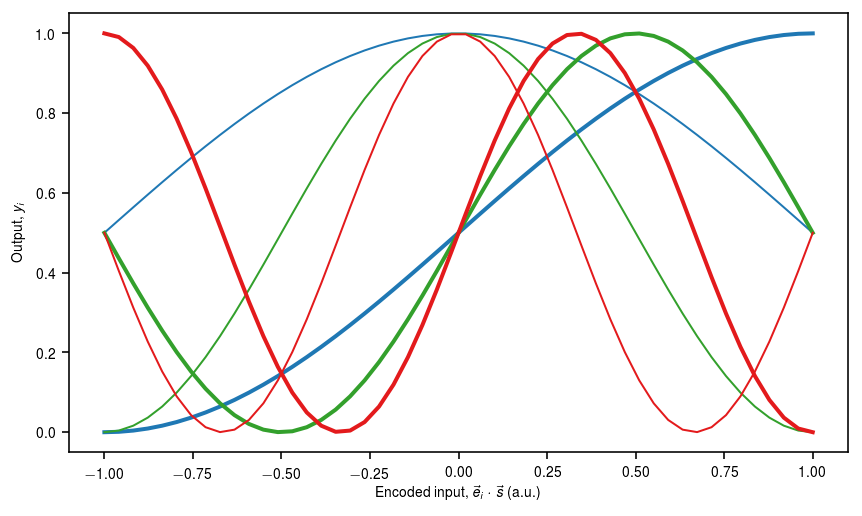

In [9]:
from nengo.utils.ensemble import tuning_curves
from nengo.utils.ensemble import response_curves

saving = False

eval_points, responses = response_curves(state, sim)
if num_neurons != np.shape(responses)[1]:
    raise Exception('Number of neurons(' + str(num_neurons) + 
                    ') and response curves(' + str(np.shape(responses)[1]) + 
                    ') is inconsistent')

if saving:
    pp = PdfPages('result_figures/tuning_curves.pdf')
fig = plt.figure(2, figsize=(6,3.6), dpi=72)
# jet = cm = plt.get_cmap('winter') 
# cNorm  = colors.Normalize(vmin=0, vmax=(num_neurons-1)/2)
cm = plt.get_cmap('Paired') 
cNorm  = colors.Normalize(vmin=0, vmax=num_neurons//num_encoders*2)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
for i in range(0, int(num_neurons//num_encoders)):
    
    # thick lines with intercept at 0 (sine wave)
    # thin lines with intercept at pi/2 shift (cosine wave)
    lw = 2-(i % 2)
    
    # different colors represent different max_rates, 
    # and therefore different gain values
    colorVal = scalarMap.to_rgba(2*(i//2)+1)
    plt.plot(eval_points, responses[:,i*(num_encoders)]/max_transmission,
             lw=lw, color=colorVal)
plt.xlabel(r"Encoded input, $\vec e_i \cdot \vec s$\ (a.u.)")
plt.ylabel("Output, $y_i$")
fig.tight_layout()
if saving:
    pp.savefig()
    pp.close()

<a id='decoding_strategy'></a>

## Decoding strategy: calculating weight matrix

![](images/Fig1.png)

As mentioned, nengo decodes a function $h(\vec x)$ from the population of neurons by a linear decoding strategy, i.e. a matrix $d^{(h)}$ resulting in an estimator $\hat h(\vec x)$:

$$\hat h(\vec x) = d^{(h)} \vec y$$
where $y_i = \sigma(s_i) =  \sigma(g_i \vec e_i \cdot \vec x + b_i)\\$.

This matrix $d^{(h)}$ is uniquely dependent on the encoder strategy, the neuron's transfer function $\sigma$ and the function $h$. As a result, it can be pre-computed before any real-time simulation. Namely, it attempts to minimize the following objective function:

$$J = \int \left\lVert d^{(h)}\vec y - h(\vec x)\right\rVert \mathrm{d}\vec x$$
where the integral is over the desired range of values of $\vec x$.

The minimum can be calculated via the Moore-Penrose pseudoinverse method ([Stewart et al. Front Neuroinform. 3 (2009)](https://doi.org/10.3389/neuro.11.007.2009)):

$$ 
\Gamma_{ij} = \int y_i y_j \mathrm{d}\vec x
$$
$$
\Upsilon_i = \int y_i h(\vec x) \mathrm{d} \vec x
$$
$$
d^{(h)} = \Gamma^{-1} \cdot \Upsilon
$$

### Weight matrix

![](images/Fig2.png)

If we add an all-to-all recurrent connection to the neural population, their collective dynamics is described by the following ODE system:

$$ \tau  \dot{\vec s} + \vec s =\overline{\overline{W}} \sigma(\vec s) + \vec I $$ 
where $\overline{\overline{W}}$ is the weight matrix and $\vec I$ a bias vector.

Nengo sets $\overline{\overline{W}} = \overline{\overline{E}} (d^{(x)} + \tau d^{(f)})$ and $\vec I = \vec b$, where $\overline{\overline{E}}_{ij} = (\vec e_i)_j$. When applied to the ODE above, it is easy to see that one can recover the Lorenz system:

$$ 
\overline{\overline{E}} (\tau  \dot{\vec x} + \vec x) = \overline{\overline{E}} (\hat{\vec x} + \tau \hat{f}(\vec x))
$$

$$ 
\Longrightarrow \dot{\vec x} = f(\vec x) + \epsilon(\vec x)
$$
where $\epsilon(\vec x) = (1/\tau) (\hat{\vec x} - \vec x) + \hat{f}(\vec x) - f(\vec x)$.

Below, we show the computed weight matrix $\overline{\overline{W}}$ for this system.

Max weight sum is [1196.93752555 1203.72081908 1234.92518093 1174.93714886 1196.93752555
 1203.72081908 1234.92518093 1174.93714886 1196.93752555 1203.72081908
 1234.92518093 1174.93714886 1196.93752555 1203.72081908 1234.92518093
 1174.93714886 1196.93752555 1203.72081908 1234.92518093 1174.93714886
 1196.93752555 1203.72081908 1234.92518093 1174.93714886]


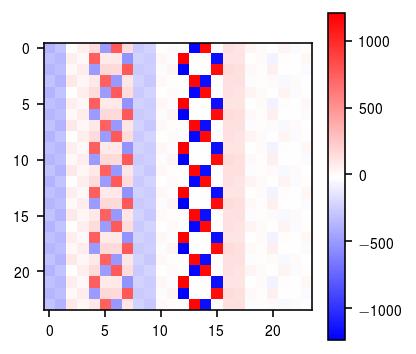

In [4]:
# The weight probe is sim.data[weight_probe][0,:,:], 
# but that gives the best approx to (x0, x1, x2)
# What we actually want is the interconnection matrix.
# For that, you need to encode this vector using the encoders variable.
weight_matrix = np.dot(encoders, sim.data[weight_probe][0,:,:])

saving = False
if saving:
    pp = PdfPages('result_figures/weight_matrix.pdf')
fig = plt.figure(3, figsize=(3,3), dpi=72)
plt.imshow(weight_matrix, cmap='bwr', interpolation='nearest')
plt.colorbar()
if saving:
    pp.savefig()
    pp.close()
print('Max weight sum is', np.max(np.abs(weight_matrix), axis=1))

<a id='solved_ode'></a>

## Solved ODE: Decoded ODE traces

Now let's plot the decoded outputs of the neuron look like when we decode for $\vec{x}$ using $d^{(x)} \vec s$. Observe the emergence of the Lorenz attractor butterfly shape.

In [5]:
from mpl_toolkits.mplot3d import Axes3D
saving = False

if saving:
    pp = PdfPages('result_figures/lorenz_system_3d.pdf')
fig = plt.figure(0, figsize=(6,4.8), dpi=72)
ax = fig.add_subplot(111, projection='3d')
dat3d = (sim.data[variable_probe][:, dim] for dim in range(3))
ax.plot(*dat3d, linewidth = 0.5)
ax.set_xlabel('$x_0$ (a.u.)', fontsize=12)
ax.set_ylabel('$x_1$ (a.u.)', fontsize=12)
ax.set_zlabel('$x_2$ (a.u.)', fontsize=12)
for xlabel_i in ax.get_xticklabels():
    xlabel_i.set_fontsize(12.0)
for ylabel_i in ax.get_yticklabels():
    ylabel_i.set_fontsize(12.0)
for zlabel_i in ax.get_zticklabels():
    zlabel_i.set_fontsize(12.0)

plt.tight_layout()
if saving:
    pp.savefig()
    pp.close()
    pp = PdfPages('result_figures/lorenz_time_traces.pdf')
fig = plt.figure(1, figsize=(6,4.8), dpi=72)
for variable, label in zip(sim.data[variable_probe].T, 
                           ['$x_0$', '$x_1$', '$x_2$']):
    plt.plot(sim.trange(), variable, label=label, linewidth = 0.8)
# for dvar in sim.data[delay_probe].T:
#     plt.plot(sim.trange(), dvar)
ax = plt.gca()
plt.legend(bbox_to_anchor=(0., .02, 1., .102), loc='lower center',
           ncol=3, borderaxespad=0., fontsize=12)
plt.xlabel('Time (ns)', fontsize=12)
plt.ylabel('Simulation variables, $x$ (a.u.)', fontsize=12)
for xlabel_i in ax.get_xticklabels():
    xlabel_i.set_fontsize(12.0)
for ylabel_i in ax.get_yticklabels():
    ylabel_i.set_fontsize(12.0)
plt.tight_layout()
plt.xlim((0,max(sim.trange())))
# plt.ylim(15*np.array([-1,1]))
if saving:
    pp.savefig()
    pp.close()

### Neural state time traces

Let's plot the undecoded state of each neuron i: $\vec s_i$. Observe which neurons are active vs which aren't.

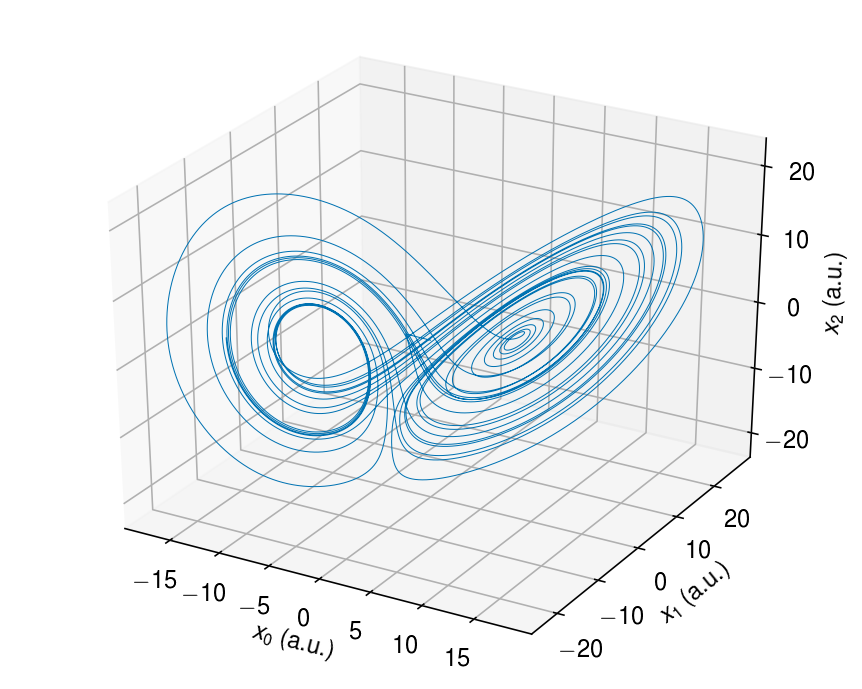

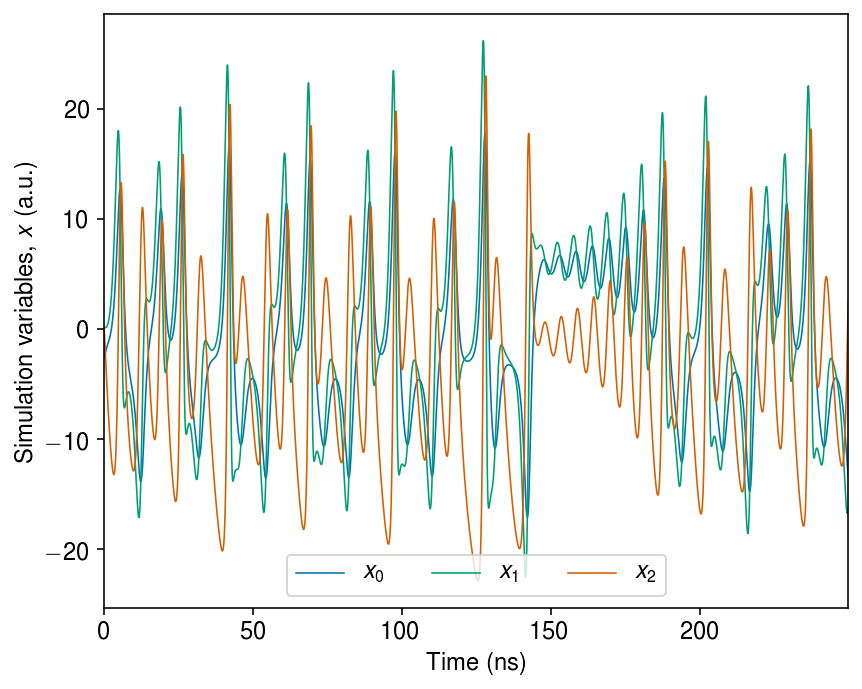

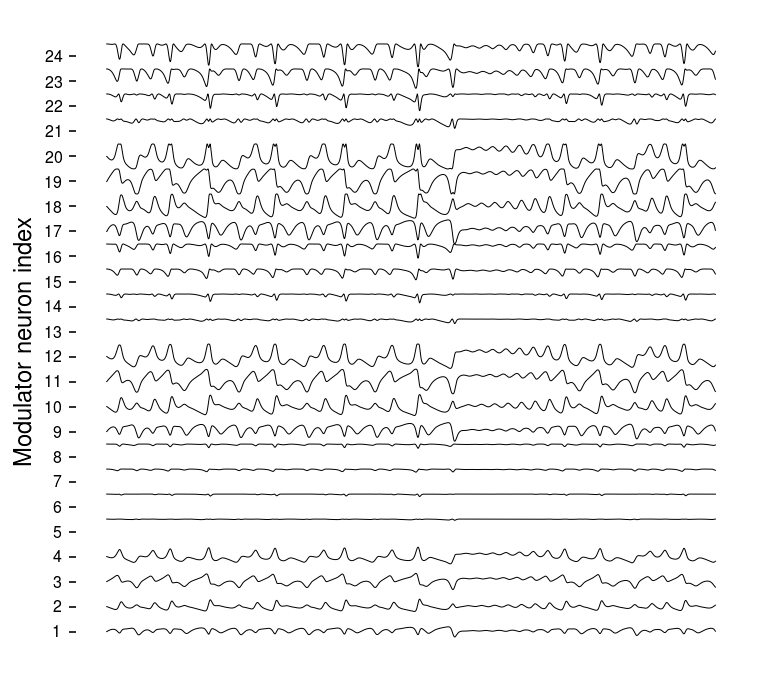

In [6]:
saving = False
if saving:
    pp = PdfPages('result_figures/MZM_time_traces.pdf')
fig = plt.figure(2, figsize=(6,6), dpi=72)
ax = plt.gca()

cm = plt.get_cmap('Paired') 
cNorm  = colors.Normalize(vmin=0, vmax=num_neurons)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
for i in range(num_neurons):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(sim.trange(), sim.data[state_probe][:, i]/max_transmission + (i+.5), 
             lw=.5, color='k')
# plt.xlabel('Real time (ns)')
plt.ylabel('Modulator neuron index', fontsize=12)
plt.xticks([])
plt.yticks(1 + np.arange(num_neurons))
ax.set_yticklabels(ax.get_yticks(), fontsize=8)
for s in ax.spines:
    ax.spines[s].set_visible(False)

if saving:
    pp.savefig()
    pp.close()

In [7]:
# Export data for further processing in matlab.
import scipy.io as sio
import os 

dataDir = 'matlab_benchmark/'
fname = os.path.join(dataDir, 'nengo_results.mat')
sio.savemat(fname, {'time':sim.trange(), 'x':sim.data[variable_probe].T})
sio.whosmat(fname)

[('time', (1, 52000), 'double'), ('x', (3, 52000), 'double')]